In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
        .appName("Stock Prediction") \
        .master("local[*]") \
        .config("spark.ui.port", "8080") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/19 23:26:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
schema = T.StructType([
  T.StructField("datetime", T.DateType()),
  T.StructField("open", T.DoubleType()),
  T.StructField("high", T.DoubleType()),
  T.StructField("low", T.DoubleType()),
  T.StructField("close", T.DoubleType()),
  T.StructField("volume", T.DoubleType()),
  ])

In [7]:
df = spark.read \
    .format("csv") \
    .option("header", True) \
    .option("mode", "FAILFAST") \
    .schema(schema) \
    .load("../data/raw/archive/D1/*.csv")

In [11]:
@F.udf(returnType=T.StringType())
def get_basename(path):
  filename = os.path.basename(path)
  filename_without_ext = os.path.splitext(filename)[0]
  return filename_without_ext.split('.')[0]

df = df.withColumn("ticket_name", get_basename(F.input_file_name()))

In [ ]:
window_spec = Window.partitionBy(F.col("ticket_name")).orderBy(F.col("ticket_name"))

In [ ]:
df = df.withColumn("VMA", F.avg("volumne").over(window_spec.rowsBetween(-2, 0))) \
  .withColumn("vol_change", (F.col("volume") - F.lag("volume").over(window_spec)) / F.lag("volume").over(window_spec))

@F.udf(returnType=T.DoubleType())
def true_range(columns):
  return max(columns)
df = df.withColumn("TR", 
              true_range(
                F.col("high") - F.col("low"), 
                F.abs(F.col('high') - F.lag('close').over(window_spec)), 
                F.abs(F.col('low') - F.lag('close').over(window_spec))
                ))

DataFrame[datetime: date, open: double, high: double, low: double, close: double, volume: double, ticket_name: string, price_change: double, daily_return: double, log_return: double, TR: double]

In [39]:
df = df.withColumn("formatted_timestamp", F.to_timestamp("datetime", "MM/dd/yyyy hh:mm:ss")) \
  .withColumn("is_weekday", (F.dayofweek("datetime") >=2) & (F.dayofweek("datetime") <= 6)) \
  .drop("datetime")

In [8]:
df.printSchema()

root
 |-- datetime: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)



In [12]:
df_sample = df.sample(fraction=0.01).toPandas()
df_sample

,datetime,open,high,low,close,volume,ticket_name
0,1998-01-09,591.52,592.55,568.00,577.03,4933909.0,GE
1,1998-08-11,690.00,700.08,685.52,698.00,5337855.0,GE
2,1998-09-28,668.48,679.52,662.00,668.00,4987064.0,GE
3,1998-12-18,754.00,775.04,752.96,774.00,7380100.0,GE
4,1999-05-25,832.48,840.00,816.48,817.04,4931000.0,GE
...,...,...,...,...,...,...,...
28329,2023-11-01,18.58,18.90,18.41,18.90,9526253.0,KVUE
28330,2023-11-09,19.28,19.30,19.04,19.21,7747411.0,KVUE
28331,2024-01-24,20.87,20.98,20.41,20.44,9872708.0,KVUE
28332,2023-11-27,414.57,416.05,412.25,414.59,99769.0,EG


In [26]:
aapl_df = df_sample.where(df_sample['ticket_name'] == 'AAPL').dropna()

In [35]:
aapl_df.head(10)

,datetime,open,high,low,close,volume,ticket_name
7404,1998-02-03,0.15,0.16,0.15,0.16,92486912.0,AAPL
7405,1998-05-19,0.25,0.26,0.25,0.26,52651256.0,AAPL
7406,1998-06-02,0.23,0.24,0.23,0.23,43151164.0,AAPL
7407,1998-08-05,0.30,0.32,0.29,0.32,105219296.0,AAPL
7408,1998-11-09,0.33,0.33,0.31,0.32,160484800.0,AAPL
7409,1999-02-26,0.32,0.33,0.30,0.31,159966800.0,AAPL
7410,1999-10-19,0.63,0.66,0.61,0.61,242846800.0,AAPL
7411,2000-01-24,0.96,1.00,0.93,0.94,99794800.0,AAPL
7412,2000-02-10,1.00,1.01,0.97,1.01,72965200.0,AAPL
7413,2000-02-15,1.02,1.07,1.02,1.06,116659200.0,AAPL


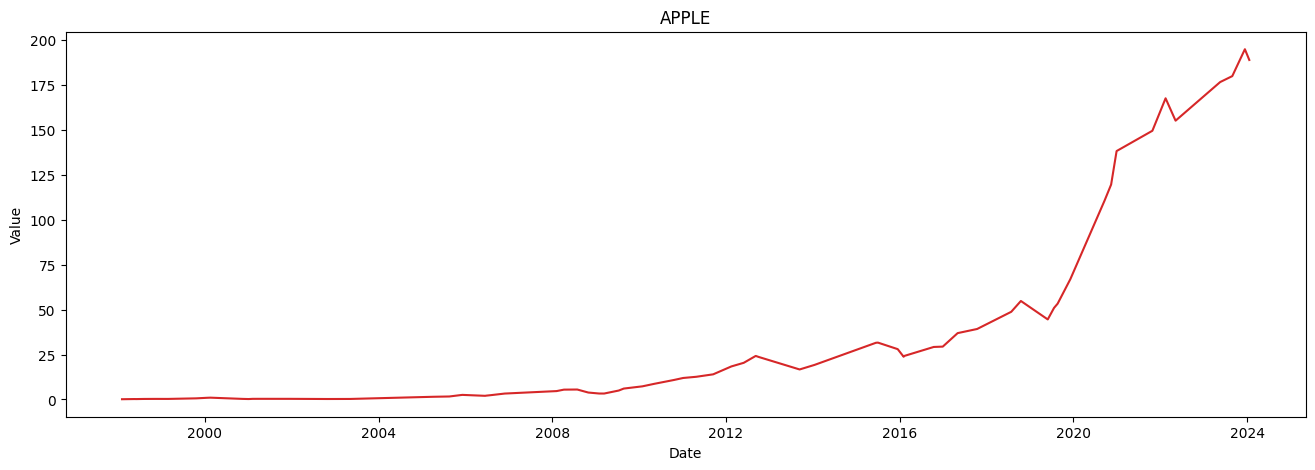

In [34]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
  plt.figure(figsize=(16,5), dpi=dpi)
  plt.plot(x, y, color='tab:red')
  plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
  plt.show()

plot_df(aapl_df, x=aapl_df['datetime'], y=aapl_df['open'], title='APPLE')